In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df_salaries = pd.read_csv('./datasets/salaries.csv')

In [ ]:
df_salaries.info()

In [ ]:
df_salaries.head(10)

In [ ]:
df_salaries_eda = df_salaries.copy()

In [ ]:
df_salaries_bucketing = df_salaries.copy()

### EDA

In [ ]:
# Detectar valores ausentes
df_salaries_eda.isna().sum()

In [ ]:
# Medidas estatísticas
df_salaries_eda.describe()

In [ ]:
# Verificar outliers
sns.boxplot(df_salaries_eda, x='tempo_na_empresa')

In [ ]:
sns.boxplot(df_salaries_eda, x='nivel_na_empresa')

In [ ]:
sns.boxplot(df_salaries_eda, x='salario_em_reais')

In [ ]:
sns.scatterplot(df_salaries_eda, x='tempo_na_empresa', y='salario_em_reais')

In [ ]:
sns.scatterplot(df_salaries_eda, x='nivel_na_empresa', y='salario_em_reais')

In [ ]:
sns.scatterplot(df_salaries_eda, x='nivel_na_empresa', y='tempo_na_empresa')

- Percebe-se visualmente que o tempo na empresa tem uma influência forte no salário em reais, mas não é uma relação linear
- Não existe relação aparente entre nível na empresa e o salário em reais e entre nível na empresa e tempo na empresa

In [ ]:
sns.pairplot(df_salaries_eda)

In [ ]:
# Mapa de calor para a correlação
# Utilizamos Spearman para captar valores não-lineares
plt.figure(figsize=(15,6))
sns.heatmap(df_salaries_eda.corr('spearman'), annot=True, vmin=-1, vmax=1)

In [ ]:
# Ranking chart
sns.heatmap(df_salaries_eda.corr('spearman')[['salario_em_reais']].sort_values(by='salario_em_reais', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

In [ ]:
# Bucketing tempo de casa
bins_company_time = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 200]
labels_company_time = ['0-9', '10-19', '20-29','30-39','40-49','50-59','60-69','70-79','80-89','90,99','100-109','110-119','120+']
df_salaries_bucketing['escala_tempo_empresa'] = pd.cut(x=df_salaries_bucketing['tempo_na_empresa'],
    bins=bins_company_time, labels=labels_company_time, right=False)

In [ ]:
df_salaries_bucketing.head(10)

In [ ]:
plt.figure(figsize=(14,8))
sns.boxplot(df_salaries_bucketing, x='escala_tempo_empresa', y='salario_em_reais')

### Treinamento de um modelo linear

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, root_mean_squared_error

In [ ]:
# Criar o dataset de treinamento e teste
X = df_salaries.drop(columns='salario_em_reais', axis=1)
y = df_salaries['salario_em_reais']

In [ ]:
# Split utilizando kfold com 5 conjuntos
kf = KFold(n_splits=5, shuffle=True, random_state=51)

In [ ]:
# Bloco para treinamento do modelo

# Pipeline
# Padronizar variáveis numéricas - tempo_na_empresa e nivel_na_empresa
numeric_columns = ['tempo_na_empresa', 'nivel_na_empresa']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns)
    ]
)

# Criando o pipeline principal = Preprocessor + training
linear_reg_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Armazenar RMSE Treinamento e Teste
rmse_scores_fold_train = []
rmse_scores_fold_test = []

# Armazenar R2 score de teste
r2scores_fold_test = []

# Armazenar resíduos
residuals = []

# Armazenar predições
y_pred_total = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Treinamento do modelo
    linear_reg_model.fit(X_train, y_train)

    # Predições nos conjuntos de treinamento e teste
    y_train_pred = linear_reg_model.predict(X_train)
    y_test_pred = linear_reg_model.predict(X_test)

    # Métricas
    rmse_scores_fold_train.append(root_mean_squared_error(y_train, y_train_pred))
    rmse_scores_fold_test.append(root_mean_squared_error(y_test, y_test_pred))
    r2scores_fold_test.append(r2_score(y_test, y_test_pred))
    residuals.append(np.array(y_test - y_test_pred))
    y_pred_total.append(y_test_pred)

rmse_train_final = np.mean(rmse_scores_fold_train)
rmse_test_final = np.mean(rmse_scores_fold_test)

r2score_test_final = np.mean(r2scores_fold_test)

percentual_rmse_final = (rmse_test_final - rmse_train_final) / rmse_train_final
residuals = np.array(residuals).reshape(-1)
y_pred_total = np.array(y_pred_total).reshape(-1)

In [ ]:
# Análise das métricas - Modelo linear
print(f'RMSE Treinamento: {rmse_train_final}')
print(f'RMSE Teste: {rmse_test_final}')
print(f'Diferença percentual entre RMSE treinamento e teste: {percentual_rmse_final * 100} %')
print(f'R2 Score teste: {r2score_test_final}')

### Análise de resíduos - Modelo linear

In [ ]:
# Transformar resíduos na escala padrão (Z)
from scipy.stats import zscore
residuals_std = zscore(residuals)

In [ ]:
# Verificar a linearidade dos resíduos: Valores entre -2 e +2 (Z)
# Verificar homocedasticidade: Valores estão em torno da reta, sem tendência ou formato
sns.scatterplot(x=y_pred_total, y=residuals_std)
plt.axhline(y=0)
plt.axhline(y=-2)
plt.axhline(y=2)

In [ ]:
# Verificar se resíduos seguem uma distribuição normal
# QQ plot
import pingouin as pg
plt.figure(figsize=(14,8))
pg.qqplot(residuals_std, dist='norm', confidence=0.95, marker='.')
plt.xlabel('Quantis teóricos')
plt.ylabel('Resíduos na escala padrão')

In [ ]:
# Teste de normalidade - Shapiro-Wilk
from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import lilliefors
stat_shapiro, p_value_shapiro = shapiro(residuals)
print(f"Estatística do teste: {stat_shapiro}, P-Value: {p_value_shapiro}")

In [ ]:
# Teste de normalidade - Kolmogorov-Smirnov
stat_ks, p_value_ks = kstest(residuals, 'norm')
print(f"Estatística do teste: {stat_ks}, P-Value: {p_value_ks}")

In [ ]:
# Teste de normalidade - Lilliefors
stat_ll, p_value_ll = lilliefors(residuals, dist='norm', pvalmethod='table')
print(f"Estatística do teste: {stat_ll}, P-Value: {p_value_ll}")

### Treinar modelo polinomial

In [44]:
# Exemplo de criação de features polinomiais
poly_feat = PolynomialFeatures(degree=3, include_bias=True)
X_poly = poly_feat.fit_transform(X)
poly_feat.feature_names_in_

array(['tempo_na_empresa', 'nivel_na_empresa'], dtype=object)

In [45]:
poly_feat.get_feature_names_out(poly_feat.feature_names_in_)

array(['1', 'tempo_na_empresa', 'nivel_na_empresa', 'tempo_na_empresa^2',
       'tempo_na_empresa nivel_na_empresa', 'nivel_na_empresa^2',
       'tempo_na_empresa^3', 'tempo_na_empresa^2 nivel_na_empresa',
       'tempo_na_empresa nivel_na_empresa^2', 'nivel_na_empresa^3'],
      dtype=object)

In [49]:
# Bloco para treinamento do modelo polinomial

polynomial_degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

rmse_train_values = []
rmse_test_values = []
percentual_rmse_values = []
r2score_test_values = []

kf = KFold(n_splits=5, shuffle=True, random_state=51)

for degree in polynomial_degrees:
    # Pipeline
    # Padronizar variáveis numéricas - tempo_na_empresa e nivel_na_empresa
    numeric_columns = ['tempo_na_empresa', 'nivel_na_empresa']
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_columns)
        ]
    )

    # Criando features polinomiais
    poly_feat = PolynomialFeatures(degree=degree, include_bias=False)

    # Criando o pipeline principal = Preprocessor + training
    poly_reg_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('poly_features', poly_feat),
        ('regressor', LinearRegression())
    ])

    # Armazenar RMSE Treinamento e Teste
    rmse_scores_fold_train = []
    rmse_scores_fold_test = []

    # Armazenar R2 score de teste
    r2scores_fold_test = []

    # Armazenar resíduos
    residuals = []

    # Armazenar predições
    y_pred_total = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Treinamento do modelo
        poly_reg_model.fit(X_train, y_train)

        # Predições nos conjuntos de treinamento e teste
        y_train_pred = poly_reg_model.predict(X_train)
        y_test_pred = poly_reg_model.predict(X_test)

        # Métricas
        rmse_scores_fold_train.append(root_mean_squared_error(y_train, y_train_pred))
        rmse_scores_fold_test.append(root_mean_squared_error(y_test, y_test_pred))
        r2scores_fold_test.append(r2_score(y_test, y_test_pred))
        residuals.append(np.array(y_test - y_test_pred))
        y_pred_total.append(y_test_pred)

    rmse_train_final = np.mean(rmse_scores_fold_train)
    rmse_test_final = np.mean(rmse_scores_fold_test)

    r2score_test_final = np.mean(r2scores_fold_test)

    percentual_rmse_final = (rmse_test_final - rmse_train_final) / rmse_train_final * 100
    residuals = np.array(residuals).reshape(-1)
    y_pred_total = np.array(y_pred_total).reshape(-1)

    rmse_train_values.append(rmse_train_final)
    rmse_test_values.append(rmse_test_final)
    r2score_test_values.append(r2score_test_final)
    percentual_rmse_values.append(percentual_rmse_final)

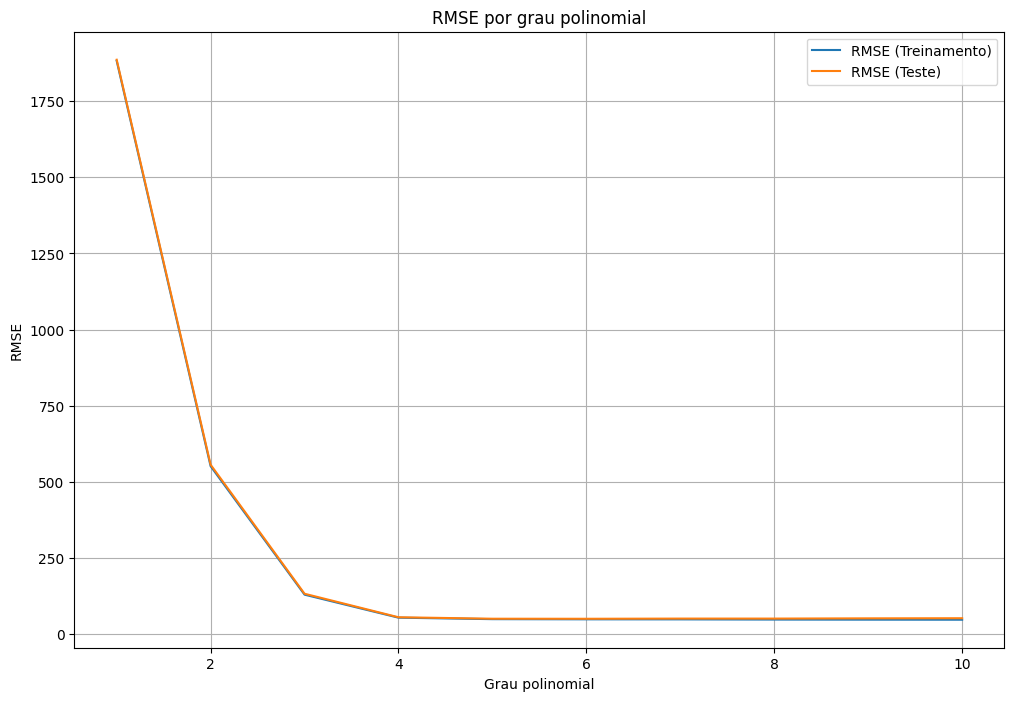

In [50]:
# Gráfico para comparação do rmse por grau polinomial
plt.figure(figsize=(12,8))
plt.plot(polynomial_degrees, rmse_train_values, label='RMSE (Treinamento)')
plt.plot(polynomial_degrees, rmse_test_values, label='RMSE (Teste)')
plt.xlabel('Grau polinomial')
plt.ylabel('RMSE')
plt.title('RMSE por grau polinomial')
plt.legend()
plt.grid(True)
plt.show()

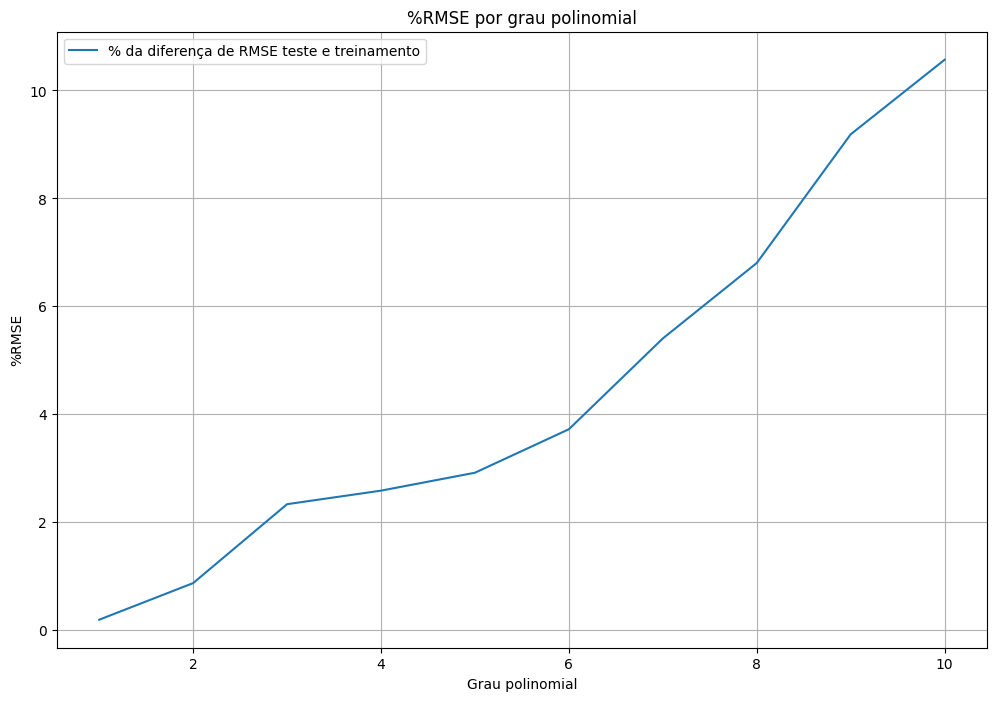

In [53]:
# Gráfico do percentual entre RMSE de treinamento e teste
plt.figure(figsize=(12,8))
plt.plot(polynomial_degrees, percentual_rmse_values, label='% da diferença de RMSE teste e treinamento')
plt.xlabel('Grau polinomial')
plt.ylabel('% Dif. RMSE')
plt.title('% Diferença entre RMSEs por grau polinomial')
plt.legend()
plt.grid(True)
plt.show()